## Empirical Interpolation Method for a non-affine parameter in a potential

Let's consider the following potential with Woods-Saxon form:

\begin{equation}
    V(r;R,a) = -\frac{V_0}{1 + \exp{\frac{r-R}{a}}}.
\end{equation}

We would like to vary $R$, $a$, and/or the momentum; $p$. For now, let's focus our attention on just $R$. First, let's apply the scaling. We now have:

\begin{equation}
  U(s,p;S,z) = -\frac{ 2 \mu V_0 }{ p^2}  \frac{1}{ (1 + \exp{ \frac{s-S}{ z }})},
\end{equation}

where we've defined $S = R p$ and $z = a p$.

Notice how our parameters of interest are distincively non-affine; for example: $U(s,p; S + S', \tilde{a}) \neq U(s,p; S, \tilde{a}) + U(s,p; S', \tilde{a})$. If we want to construct an RBM with which we can perturb $S \rightarrow S'$, we will not be able to simply construct an affine space of scattering wavefunctions with a set of training points $T = \{ S_1, S_2, ..., S_N \}$ as before. Unless perhaps we could find an approximation of $U$ (let's call it $\tilde{U}$), that was affine in $S$ ...

\begin{equation}
U(s; S)  \approx \tilde{U}(s; S)  = \sum_k^M \beta_k(S) U_k(s) 
\end{equation}

... yeah, something like that! Here, we denote $U_k(s) = U(s,S_k)$ as a "snapshot", or training point, of $U(s; S)$, evaluated at particular values $S = S_k$ ($z$ and $p$ will be fixed, so we will suppress dependence upon them going forward). $\tilde{U}(s;S)$ should interpolate $U(s;S)$ between the training points $T$.

Already, we see an analogy with what we did before in the space of wavefunctions, but now in the space of operators $U(s;S)$: we will evaluate $N$ snapshots of $U(s;S)$, with $S$ evaluated at each value on the training space $T$, which we are free to choose. As before, we will then do PCA to find $M < N$ dimensions that suitably encapsulate the information content of $U(s;S)$ as we vary $S \in T$. 

Then, we can simply plug our $M$ snapshots, $U_k(s)$ into the equation that enforces our desired interpolation:

\begin{equation}
U(s; S) = \sum_k^M \beta_k(S) U_k(s).
\end{equation}

We'll maybe not so simply, but we'll burn that bridge when we get to it. For now, let's build our training space.

First, define our constantns and potentials:

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

hbarc = 197 # MeV • fm
mass = 939 # MeV
energy = 50 # center-of-mass scattering energy, fixed for the first example
k = np.sqrt(mass*energy)/hbarc

In [36]:
def woods_saxon(r, args):
    V0, R, a = args
    return -V0/(1. + np.exp((r-R)/a))
    
def woods_saxon_tilde(s, args):
    V0, R, a = args
    return 1./energy * woods_saxon(s/k, (V0, R, a))

# interaction parameters we will use for testing
V0 = 200 # MeV
a  = 0.5 # fm

In [37]:
# create N random points, distributed evenly, on our desired range
# it is inexpensive to simply evaluate a potential, so might as well 
# use a large number of training points
N = 1000

# logarithmically evenly
def generate_rand_log(log_min, log_max, N=40):
    return np.sort(np.exp( np.random.rand(N) * (log_max - log_min) + log_min ))

# linearly evenly
def generate_rand_lin(lin_min, lin_max, N=40):
    return np.sort(np.random.rand(N) * (lin_max - lin_min) + lin_min)

# let's take a physical range
R_min = 1
R_max = 6
T = np.arange(R_min, R_max, (R_max - R_min)/N) 
#T = generate_rand_log(np.log(R_min), np.log(R_max), N=N)

In [38]:
def Utrain(s):
    """
    Takes in an array of s values, spits out a matrix of the Woods-Saxon reduced potential
    evaluated at those s and each S value on T
    """
    #TODO this is hacky af
    tmp = np.zeros(np.outer(s,T).shape)
    TT = tmp + T 
    SS = tmp.T + s
    return np.array([ woods_saxon_tilde(SS.T, (V0, TT, a)) ])[0].T

In [39]:
r = np.arange(0,10, 1E-2)
s = r*k
Umat = Utrain(s)


Text(0, 0.5, '$U$ [a.u.]')

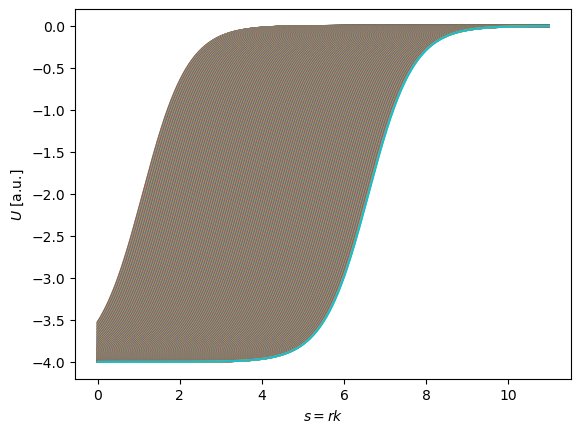

In [40]:
for i in range(N):
    plt.plot(s, Umat[i,:])
plt.xlabel(r"$s = r k$")
plt.ylabel(r"$U$ [a.u.]")
#plt.show()


Great, we have a healthy training set of potentials. We would expect that the diffraction minima in differential elastic scattering cross sections, for example, to be quite sensitive to the $R$ value of a Woods-Saxon potential. In other words, all those potentials would produce very different cross-sections! Now let's do PCA and keep just the few that encapsulate most of this information.


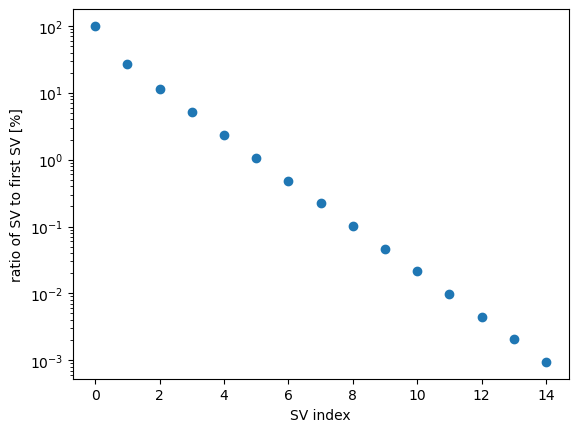

In [41]:
# how big is our final basis?
U, S, Vt = np.linalg.svd(Umat.T, full_matrices=False)
plt.semilogy(100*S[:15]/S[0], "o", linestyle="None")
plt.xlabel("SV index")
plt.ylabel("ratio of SV to first SV [%]")
plt.show()

These singular values are dropping nicely; let's take only the first few. 

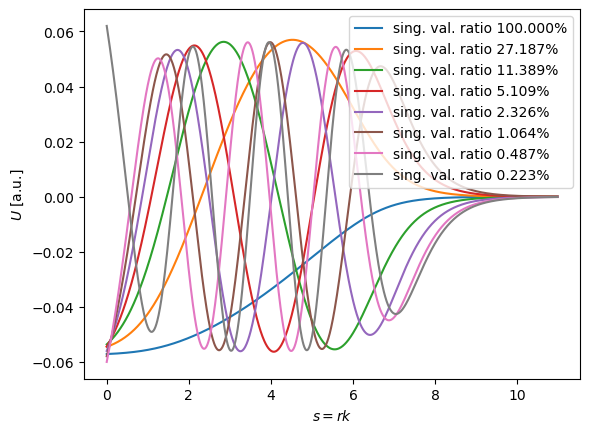

In [42]:
M = 8 # definitely less than N!
for i in range(M):
    plt.plot(s, U[:,i], label="sing. val. ratio {:1.3f}%".format(100*S[i]/S[0]))
plt.xlabel(r"$s = r k$")
plt.ylabel(r"$U$ [a.u.]")
plt.legend()
plt.show()

Great, we have our basis $U_k(s)$. We only need 4 elements to represent most of the information encapsulated in our training set! Now we would like to determine our $M$ coefficients, $\beta_k(S)$. If we evaluate the interpolation equation at $M$ values of $s$, we have $M$ equations, which pairs quite nicely with out $M$ unknown coefficients. But what values of $s$ should we choose? 

Intuitively, we should choose the $s$ values which provide the most information - the places where the variance in potential values between the different parameters is highest. Let's take a look at the standard deviation of our training set as a function of $s$:

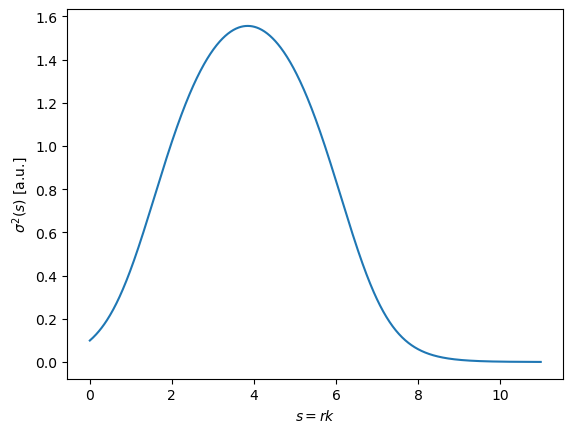

In [43]:
plt.plot(s, np.sqrt(np.var(Umat, axis=0)) )
plt.xlabel(r"$s = r k$")
plt.ylabel(r"$\sigma^2(s)$ [a.u.]")
plt.show()

As a first pass, let's choose $M$ points, $s_k$, roughly sampled (by eye) this distribution, and simultaneously solve our interpolation equation at those points. There are certainly better ways to pick points - e.g. a greedy algorithm that chooses points in a correlated way, choosing the next point based on the variance remaining after choosing the previous points. We'll stick with our simple uncorrelated method for now - we can always refine later.

In [44]:
#TODO sampling scheme is very high variance for small M
#TODO add greedy algo
ps = np.sqrt(np.var(Umat, axis=0))

# normalize
ps /= np.trapz(ps, x=s)
ps /= np.sum(ps)

# this method actually sucks
sample_pts = np.random.choice(s, size=M, p=ps)

# instead let's choose points by hand
sample_pts = np.linspace(0.1,8,M)

In [45]:
sample_pts


array([0.1       , 1.22857143, 2.35714286, 3.48571429, 4.61428571,
       5.74285714, 6.87142857, 8.        ])

We know want to solve an equation of the form

\begin{equation}
\mathbf{A} \overline{x}(S) = \overline{b}(S),
\end{equation}

where 

\begin{equation}
{b}_{j} = U(s_j,S),
\end{equation}
and 
\begin{equation}
{A}_{jk} = U_j(s_k),
\end{equation}

and our unkown coefficient functions,
\begin{equation}
{x}_{k} = \beta_k(S).
\end{equation}

In [46]:
A = np.zeros((M,M))
for j in range(M):
    A[:,j] = np.interp( sample_pts, s, U[:,j])

Let's take a look at our potential evaluated at our $M$ chosen sample points, over the range of $S$ values in $T$.

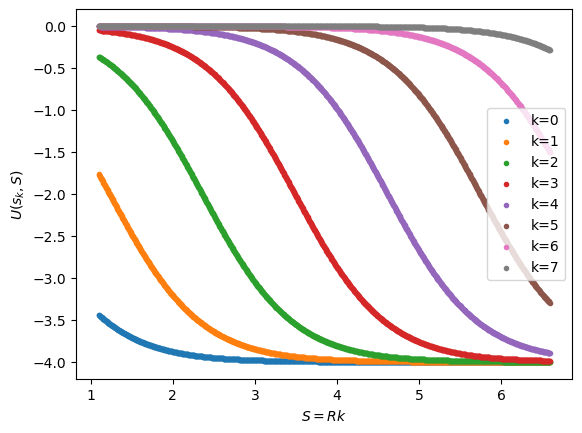

In [47]:
b = np.zeros((M,N))
for ki in range(M):
    b[ki,:] = woods_saxon_tilde(sample_pts[ki], (V0, T, a))
    plt.scatter(k*T, woods_saxon_tilde(sample_pts[ki], (V0, T, a)), 
                marker='.', label="k={}".format(ki))
plt.xlabel(r"$S = R k$")
plt.ylabel(r"$U(s_k,S)$")
plt.legend()
plt.show()

In [48]:
# solve the system to find the coefficient functions
x = np.einsum('jk,k...', np.linalg.inv(A), b)

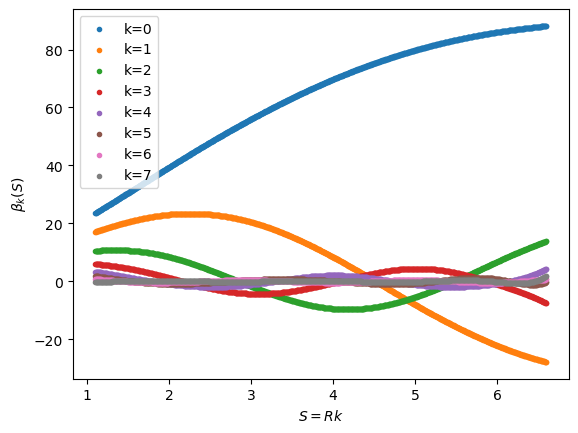

In [49]:
for j in range(M):
    plt.scatter(k*T, x[:,j],  marker='.', label="k={}".format(j))
plt.xlabel(r"$S = Rk$")
plt.ylabel(r"$\beta_k(S)$")
plt.legend()
plt.show()

Intuitively, we see that the coefficients generally decrease in magnitude with the singular value, which is a good sanity check. Now let's put it all together to test our affine decomposition of the potential.

In [50]:
def ws_affine_decomp(s, args, R_grid):
    '''
    affine decomposition of our Woods-Saxon potential
    '''
    V0, R, a = args
    S = R*k
    
    betas = np.zeros(M)
    Uad   = np.zeros_like(s)

    for i in range(M):
        betas[i] = np.interp(S, k*R_grid, x[:,i])
        Uad += betas[i] * U[:,i]
    print(betas)
    return Uad

[ 8.33553709e+01 -1.57112772e+01  2.51788685e-01  2.91956581e+00
 -1.87386053e+00  8.81471207e-01 -2.58858767e-02  3.47661749e-01]


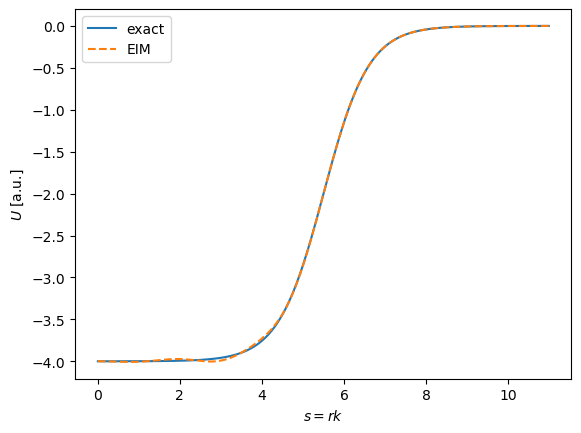

In [51]:
R_test = 5
plt.plot(s, woods_saxon_tilde(s, (V0, R_test, a)),  label="exact")
plt.plot(s, ws_affine_decomp(s, (V0, R_test, a), T), '--', label="EIM")

plt.xlabel(r"$s = r k$")
plt.ylabel(r"$U$ [a.u.]")
plt.legend()
plt.show()

Nice, kinda. By messing with the choice of sample points, we can see this method is very sensitive to the choice. This motivates the need for a greedy algorithm that can optimally choose the next sample point to maximize the variance, conditional on the initial set.